## Expected Batting Average

### About

- This project aims to replicate the MLB statcast advanced stat "xBA"

### Goals

1) Use supervised ML to predict whether a batted ball is a hit ot an out based on:
    - Pitch velo
    - Exit velo
    - Launch angle
    - Hit location
    - Hit distance (in case HRs aren't given their own hit location?)
    - Batter speed (maybe)
    
2) Find the *expected* batting average for a batter given the above parameters for each batted ball in play 

3) Compare results with statcast's xBA results

### Data

- Data gathered from baseball savant (statcast) search
- Example search query to get all (?) batted balls resulting in outs in 2018 
    - https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=single%7Cdouble%7Ctriple%7Chome%5C.%5C.run%7Cfield%5C.%5C.out%7Cstrikeout%7Cstrikeout%5C.%5C.double%5C.%5C.play%7Cdouble%5C.%5C.play%7Cgrounded%5C.%5C.into%5C.%5C.double%5C.%5C.play%7Cfielders%5C.%5C.choice%7Cfielders%5C.%5C.choice%5C.%5C.out%7Cforce%5C.%5C.out%7Csac%5C.%5C.bunt%7Csac%5C.%5C.bunt%5C.%5C.double%5C.%5C.play%7Csac%5C.%5C.fly%7Csac%5C.%5C.fly%5C.%5C.double%5C.%5C.play%7Ctriple%5C.%5C.play%7C&hfBBT=&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7C&hfC=&hfSea=2018%7C&hfSit=&player_type=batter&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfInfield=&team=&position=&hfOutfield=&hfRO=&home_road=&hfFlag=&hfPull=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_pas=0#results
    - seems like this returns a maximum of 40,000 results
- Data reference
    - https://baseballsavant.mlb.com/csv-docs

### Notes

- My plan is to use 2018 results in the training/test sets to determine 2019 xBA results
    - Need to think more about if this is the right strategy
- Is it possible to get spray chart info for this?
- Having hc_x and hc_y as two separate features doesn't really tell us much, we need the combination of the two as a vector:
    - $ hc = \sqrt{hc_y^2 + hc_x^2} \tan(y/x) $
    - ATTN: getting weird values here, need to plot to see if it makes sense

In [66]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import neighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from confusion import plot_confusion_matrix
import seaborn as sns
from IPython.display import display, clear_output
%matplotlib inline

hits = ['single', 'double', 'triple', 'home_run']
sacs = ['sac_fly', 'sac_bunt', 'sac_bunt_double_play', 'sac_fly_double_play']

def spray_angle(df):
    '''
        Calculate spray angle from hc_x and hc_y in statcast csv output
    '''
    # make home plate (0,0)
    hc_x = df['hc_x'] - 125.42
    hc_y = 198.27 - df['hc_y']
    df['spray_angle'] = np.arctan(hc_x/hc_y)
    df.loc[df['stand'] == 'L', 'spray_angle'] = -df.loc[df['stand'] == 'L', 'spray_angle']
    # convert to degrees
    df['spray_angle'] = df['spray_angle'].apply(np.rad2deg)
    return(df)

def pre_process(df):
    '''
          Process dataframe for KNN, break df into features and results
    '''
    # define features
    df = df.copy()
    features = [
        'launch_speed', 'launch_angle', 'spray_angle'
    ]
    # remove home runs (not in play)
    df = df[df['events'] != 'home_run']
    # remove sacrifices (not ABs)
    df = df[~df['events'].isin(sacs)]
    # add outcome column
    df['hit'] = (df['events'].isin(['single', 'double', 'triple']))
    # process df
    df = spray_angle(df)
    # break into features (X) and outcomes (y)
    X, y = df[features], df['hit']
    return(X, y)

def calc_BABIP(df):
    '''
        Calculate BABIP from statcast csv output
    '''
    H = len(df[df['events'].isin(hits)])
    HR = len(df[df['events'] == 'home_run'])
    sac = len(df[df['events'].isin(sacs)])
    field_out = len(~df['events'].isin([*hits, *sacs]))
    return((H - HR)/(field_out - HR + sac))
    

# import and pre-process the data
data = pd.read_csv('data/batted_balls_2018.csv')
X, y = pre_process(data)

## Exploring the dataset

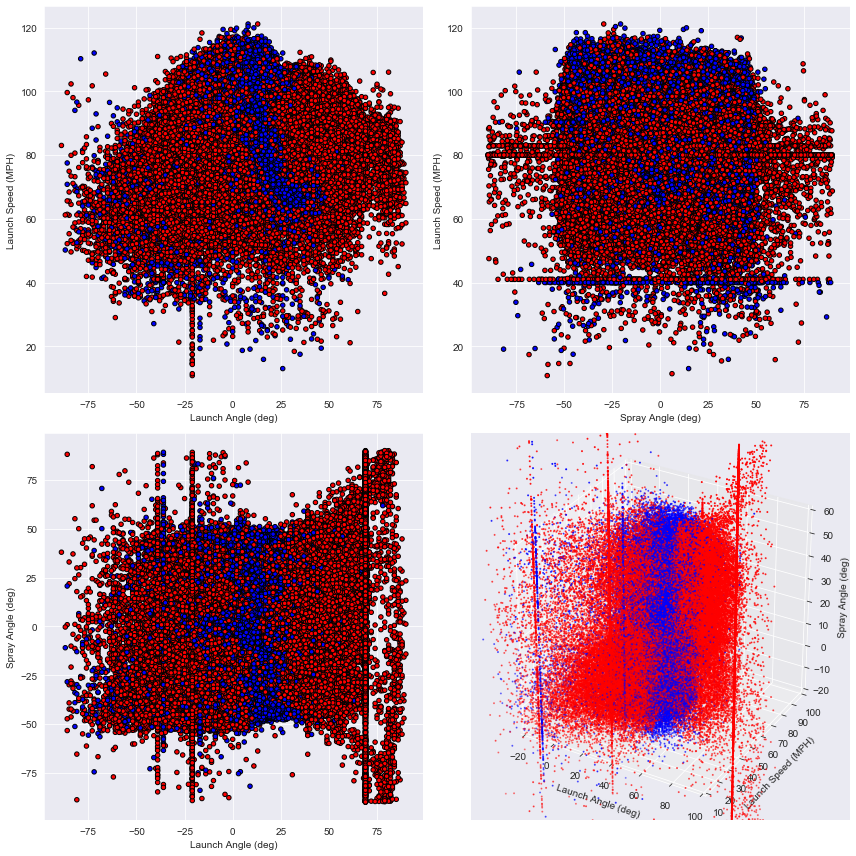

In [67]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# plot outs as red, hits as blue
colors = pd.DataFrame(y.copy())
colors['colors'] = 'red'
colors.loc[colors['hit'] == 1, 'colors'] = 'blue'
colors = np.array(colors['colors'])

# launch angle vs. launch speed
ax[0,0].scatter(X['launch_angle'], X['launch_speed'], s=20, c=colors, edgecolors='black', linewidth=1)
ax[0,0].set_xlabel('Launch Angle (deg)')
ax[0,0].set_ylabel('Launch Speed (MPH)')

# spray angle vs. launch speed
ax[0,1].scatter(X['spray_angle'], X['launch_speed'], s=20, c=colors, edgecolors='black', linewidth=1)
ax[0,1].set_xlabel('Spray Angle (deg)')
ax[0,1].set_ylabel('Launch Speed (MPH)')

# spray angle vs. launch speed
ax[1,0].scatter(X['launch_angle'], X['spray_angle'],  s=20, c=colors, edgecolors='black', linewidth=1)
ax[1,0].set_xlabel('Launch Angle (deg)')
ax[1,0].set_ylabel('Spray Angle (deg)')

# 3D plot of all features
for val in ['top', 'bottom', 'left', 'right']:
    ax[1,1].spines[val].set_visible(False)
ax[1,1].tick_params(
    axis='x', which='both',
    top=False, bottom=False
)
ax[1,1].tick_params(
    axis='y', which='both',
    left=False, right=False
)
ax[1,1].set_yticklabels('')
ax[1,1].set_xticklabels('')
ax = fig.add_subplot(224, projection='3d')

ax.scatter(
    X['launch_angle'], X['launch_speed'], X['spray_angle'],
    c=colors, s=1,
)
ax.set_ylim([10, 100])
ax.set_xlim([-20, 100])
ax.set_zlim([-20, 60])

ax.set_ylabel('Launch Speed (MPH)')
ax.set_xlabel('Launch Angle (deg)')
ax.set_zlabel('Spray Angle (deg)')
fig.tight_layout()
plt.show()
fig.savefig('feature_exploration.png', dpi=300)

#### Notes

- There seems to be some spurious data here
    - groups with constant launch angle and speed for various spray angles...

In [68]:
data[data['launch_speed'] == 80.0].head()

,events,description,batter,stand,launch_angle,launch_speed,hc_x,hc_y,pitcher,p_throws,pitch_type,release_speed,release_spin_rate,hit
41,field_out,hit_into_play,571448,R,69.0,80.0,169.98,202.90,621111.0,R,SL,85.9,3117.0,False
49,field_out,hit_into_play,456124,R,69.0,80.0,151.94,191.82,448802.0,L,FF,89.1,2439.0,False
118,field_out,hit_into_play,571851,R,69.0,80.0,188.90,159.11,542881.0,L,FF,92.1,2377.0,False
124,field_out,hit_into_play,543685,R,69.0,80.0,155.59,157.29,542881.0,L,CH,81.5,1746.0,False
131,field_out,hit_into_play,645302,R,69.0,80.0,160.44,188.79,542881.0,L,CH,79.6,1990.0,False


- There are a ton of data points with LA = 69.0 and LS = 80.0 that are outs
    - This is just a common weak pop up I think?
- Launch speed of 40 mph could be bunts?
    - In spray_angle vs. launch_speed there are two rows with contant launch_speed=40mph 
        - One row could be successful bunts and the others bunts for outs
    - Yup, I checked in baseball savant and bunts are around 40 mph exit velocity
- Going to move forward for now, but need to think about the other "spurious" groups

## Creating the Model

Accuracy of KNN classifier on training set: 1.00
Accuracy of KNN classifier on test set: 1.00

Expected BABIP for Dee Gordon: 0.303
Actual BABIP: 0.300


Expected BABIP for Edwin Encarnacion: 0.295
Actual BABIP: 0.230

Normalized confusion matrix
[[0.85542169 0.14457831]
 [0.35897436 0.64102564]]
Normalized confusion matrix
[[0.81981982 0.18018018]
 [0.34285714 0.65714286]]


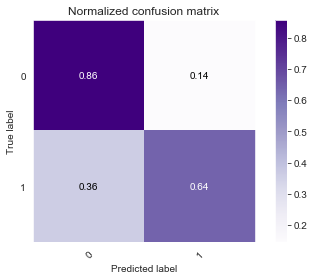

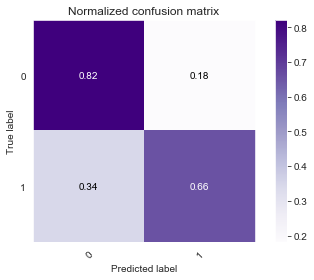

In [69]:
# split up data into train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 0
)

# K-Nearest Neighbors 
nn = 1
clf = neighbors.KNeighborsClassifier(nn)
clf.fit(X, y)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

# calculate expected batting average for a couple players
dee = pd.read_csv('data/dee_gordon_2019.csv')
edwin = pd.read_csv('data/edwin_encarnacion.csv')

X_dee, y_dee = pre_process(dee)
X_edwin, y_edwin = pre_process(edwin)

predicted_outcomes_dee = clf.predict(X_dee)
unique, counts = np.unique(predicted_outcomes_dee, return_counts=True)
d = dict(zip(unique, counts))
xBABIP_dee = d[True]/(d[False] + d[True])

predicted_outcomes_edwin = clf.predict(X_edwin)
unique, counts = np.unique(predicted_outcomes_edwin, return_counts=True)
d = dict(zip(unique, counts))
xBABIP_edwin = d[True]/(d[False] + d[True])

BABIP_dee = calc_BABIP(dee)
BABIP_edwin = calc_BABIP(edwin)

print('\nExpected BABIP for Dee Gordon: {:.3f}'.format(xBABIP_dee))
print('Actual BABIP: {:.3f}\n'.format(BABIP_dee))
print('\nExpected BABIP for Edwin Encarnacion: {:.3f}'.format(xBABIP_edwin))
print('Actual BABIP: {:.3f}\n'.format(BABIP_edwin))

sns.set_style('dark')
plot_confusion_matrix(y_dee, predicted_outcomes_dee, [0, 1], normalize=True)
plot_confusion_matrix(y_edwin, predicted_outcomes_edwin, [0, 1], normalize=True)
plt.show()

#### Notes

- Worried about overfitting here, though the results for dee and edwin make sense

## Defining xBABIP+ and BAASH

- Borrowing from general sabermetric nomenclature:
    - "x" denotes "expected"
    - "+" denotes normalization such that league average is 100, and 110 is 10% better than average
- An expected BABIP could be league average BABIP, then xBABIP+ would be BABIP - league_avg(BABIP) --> normalize to 100
    - This doesn't separate the three main types of players that might have higher than avg BABIP
        1. Players who hit the ball *really* hard
        2. Players who are fast
        3. Player who are lucky
    - OK, so we can't really sort out the lucky players, but we can sort out the hard hitters from the fast runners...
- By calculated xBABIP using a model and a players launch speed, angle, and spray angle, we account for the hard hitter
    - If a hitter it always either striking out or mashing the ball, their BABIP would be pretty high, but their **predicted** BABIP based on statcast data would account for this
    - Now, the players that don't mash the ball but are fast will have relatively lower predicted BABIP, but a higher actual BABIP 
- Thus, xBABIP+ is more of a speed and hustle stat (note: "hustle" has some problems...)
- Let's give it it's own jargon: **BAASH** 
    - Batting Average Added from Speed and Hustle
    - we could normalize to BAASH+, but it's probably more intuitive to stay in units of BA
- Now, we have an ironically named stat for speed!

## BAASH Rankings for 2019

In [70]:
# remove players with fewer than 100 ABs
data2019 = pd.read_csv('data/batted_balls_2019.csv')
AB100 = []
for pid in data2019['batter'].unique():
    if data2019.loc[data2019['batter'] == pid].shape[0] >= 100 and pid not in AB100:
        AB100.append(pid)


# length of AB100 is 195
BABIP, xBABIP, BAASH = [], [], []
BAASHd = {}
for i, pid in enumerate(AB100):
    clear_output()
    print('Processing {:d}/{:d}'.format(i+1, len(AB100)) + ' Player IDs...')
    pdata = data2019.loc[data2019['batter'] == pid].copy()
    Xp, yp = pre_process(pdata)
    predicted_outcomes = clf.predict(Xp)
    unique, counts = np.unique(predicted_outcomes, return_counts=True)
    d = dict(zip(unique, counts))
    xBABIP = d[True]/(d[False] + d[True])
    
    BABIP = calc_BABIP(pdata)
    BAASH = BABIP - xBABIP
    BAASHd[pid] = [round(BABIP, 3), round(xBABIP, 3), round(BAASH, 3)]

Processing 215/215 Player IDs...


## Process BAASH Results

In [195]:
import pybaseball as pbb
pd.set_option('display.max_columns', 100)
# convert to dataframe
results = pd.DataFrame.from_dict(BAASHd, orient='index')
results.columns = ['cBABIP', 'xBABIP', 'BAASH']
results.index.name = 'mlb_id'

# match player_id to player name
# map from http://crunchtimebaseball.com/baseball_map.html
# current as of 9 June 2019
id_map = pd.read_csv('data/player_id_map.csv', encoding='Latin-1', index_col='fg_name')
# keep only the info we might use later
id_map = id_map[['mlb_id', 'mlb_name', 'fg_id']]
# import fangraphs batting data from 2019
fg_batting = pd.read_csv('data/FanGraphs_Leaderboard_2019.csv')
fg_batting = fg_batting.sort_values('Name') \
                        .rename(columns = {'Name': 'fg_name'}) \
                        .join(id_map, on='fg_name', how='left') \
                        .set_index('mlb_id', drop=True).drop(['playerid', 'fg_id', 'fg_name'], axis=1) \
                        .rename(columns = {'mlb_name': 'Name'})

cols = [fg_batting.columns.tolist()[-1], *fg_batting.columns.tolist()[:-1]]
fg_batting = fg_batting[cols]
# join results and fg_batting
results = fg_batting.join(results, on='mlb_id', how='left').dropna()
results.sort_values(by='BAASH', inplace=True, ascending=False)
results['BABIP_diff%'] = round(((results['BABIP'] - results['cBABIP']).abs()/results['cBABIP'])*100, 1)
results['BAASH2'] = results['BABIP'] - results['xBABIP']
speed = pd.read_csv('data/sprint_speed.csv', index_col='player_id')
speed.index.name = 'mlb_id'
speed = speed[['hp_to_1b', 'sprint_speed']]
results = results.join(speed, how='outer')

/home/rusty/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


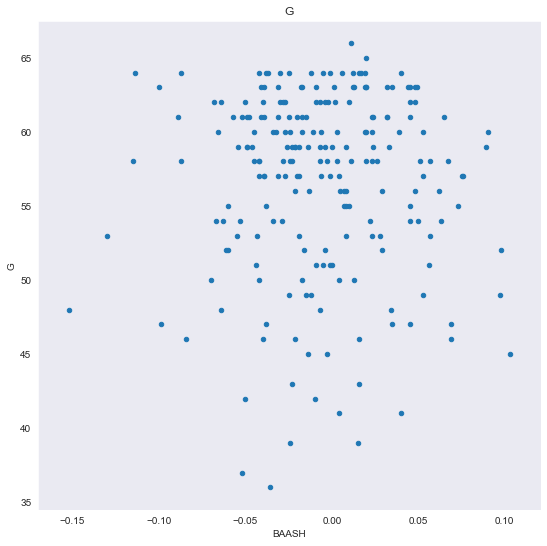

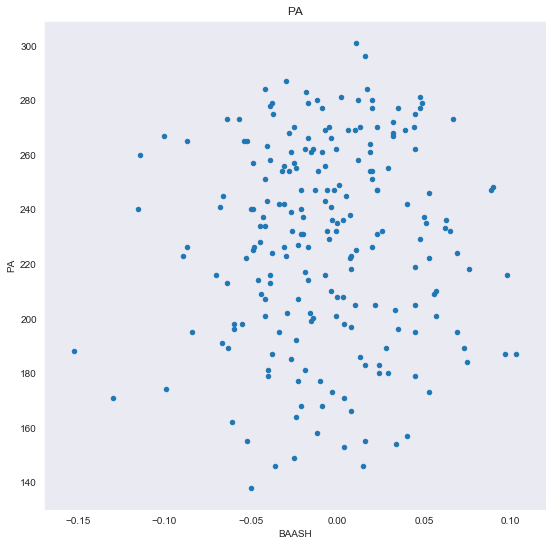

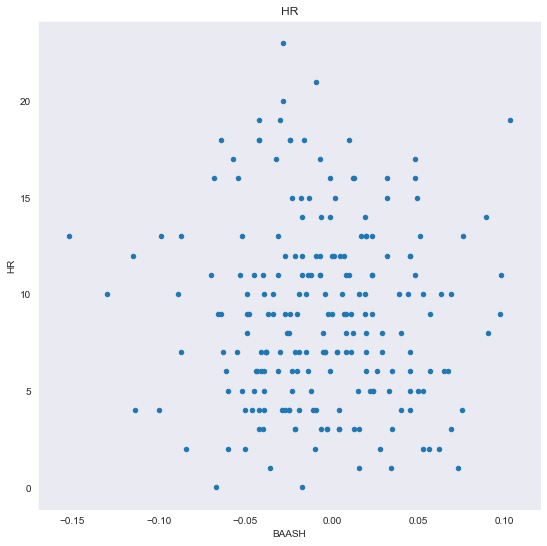

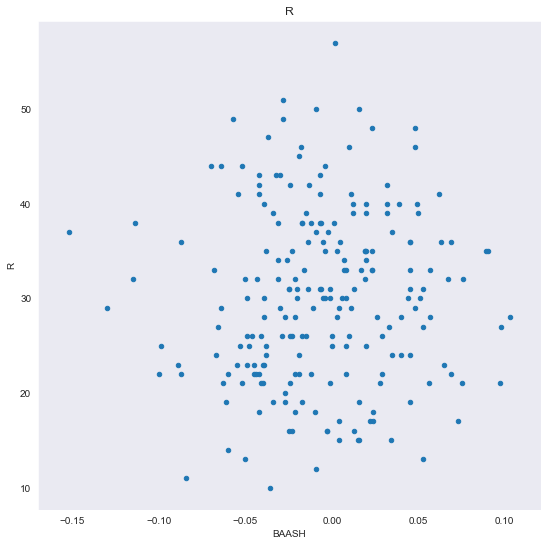

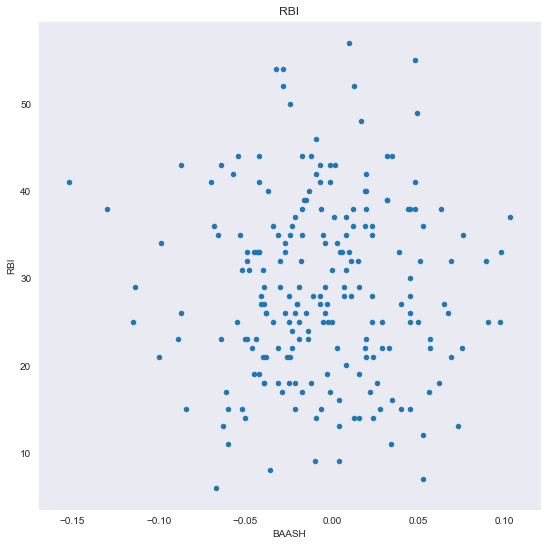

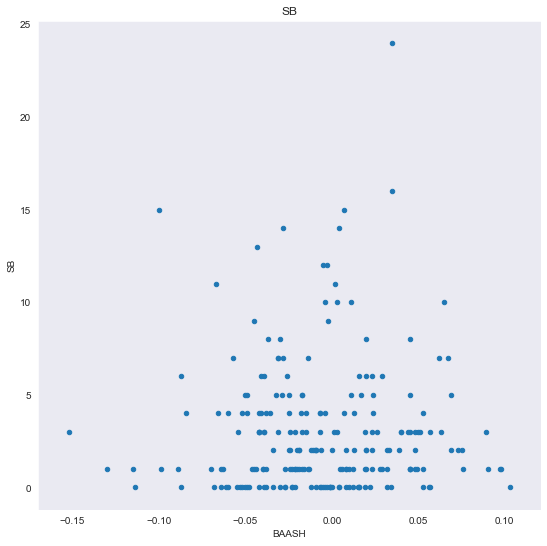

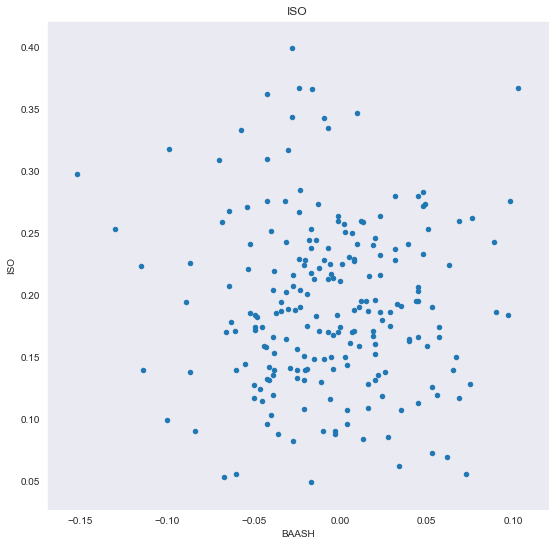

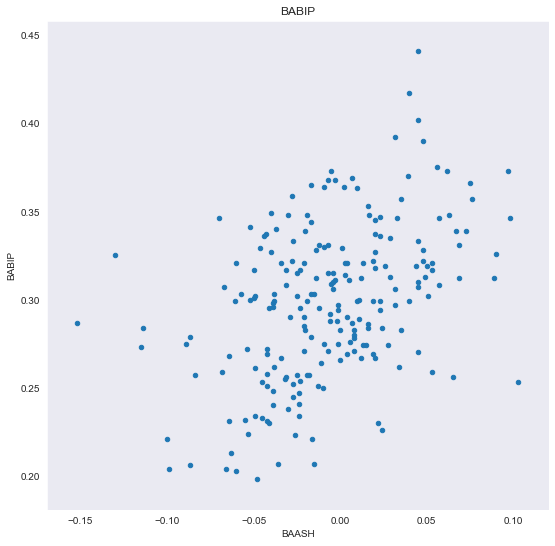

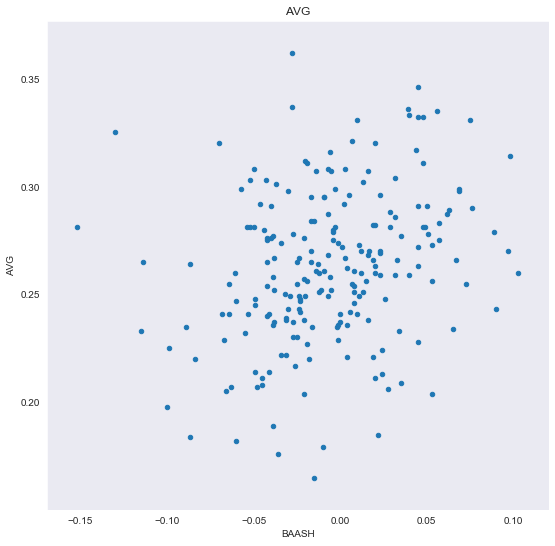

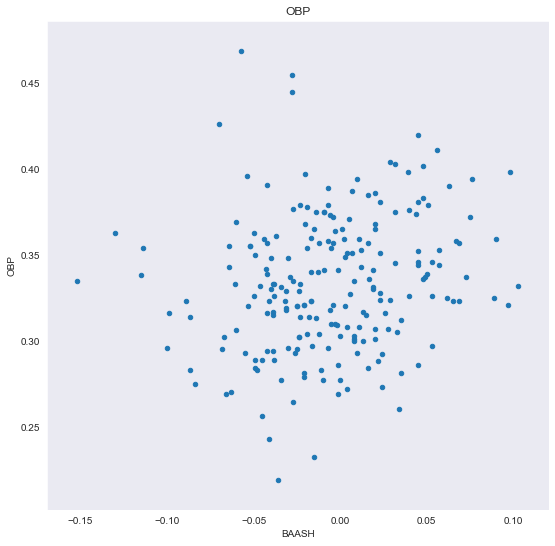

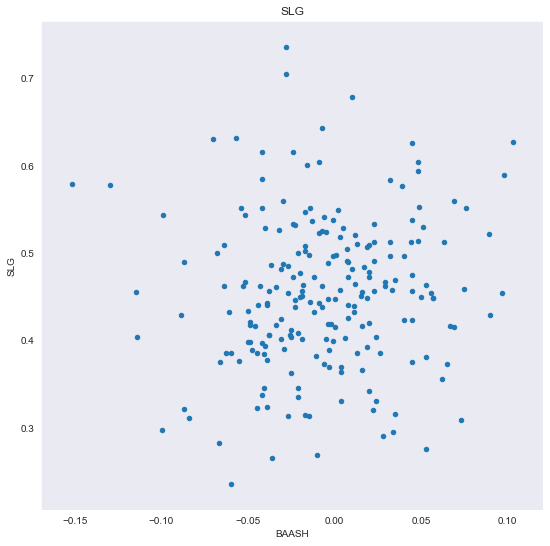

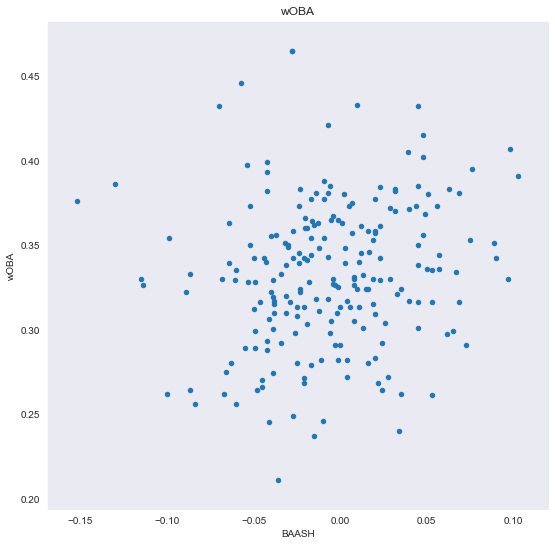

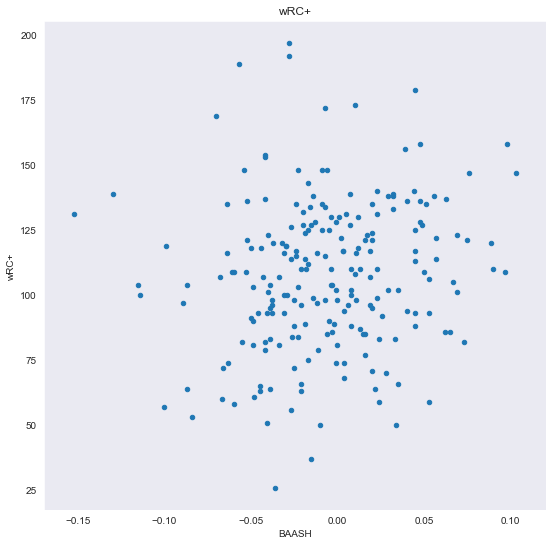

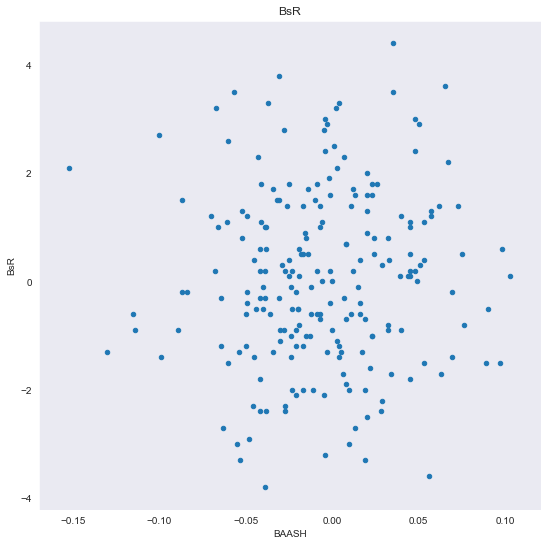

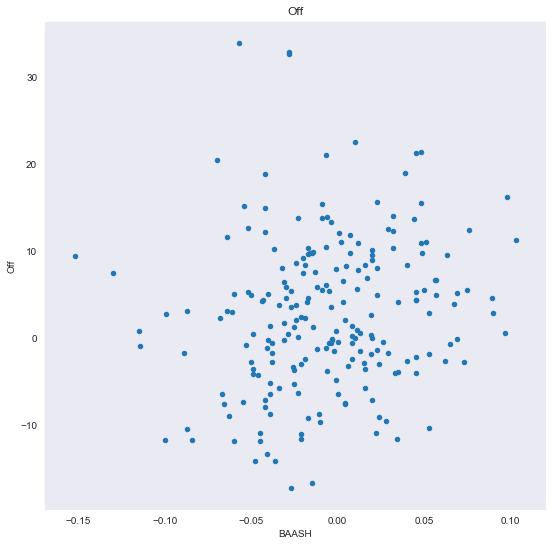

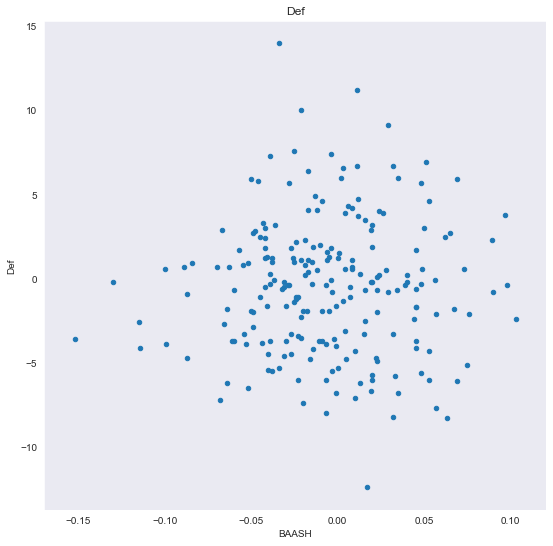

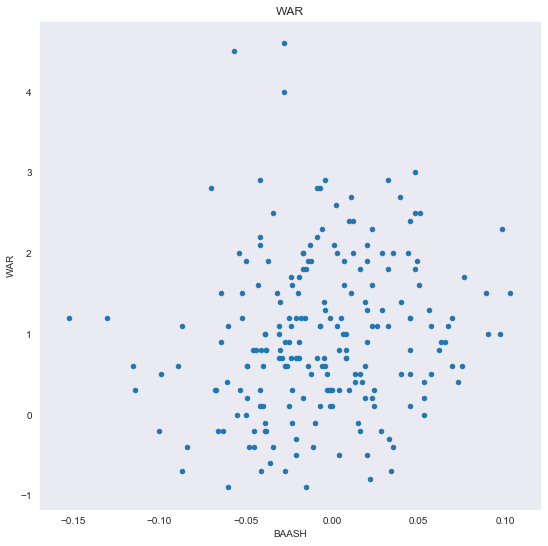

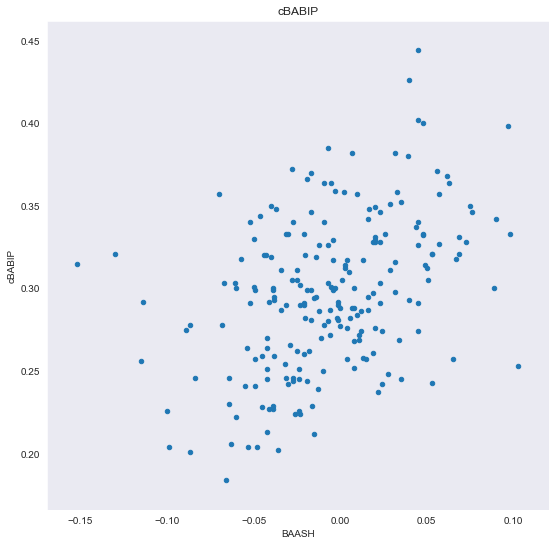

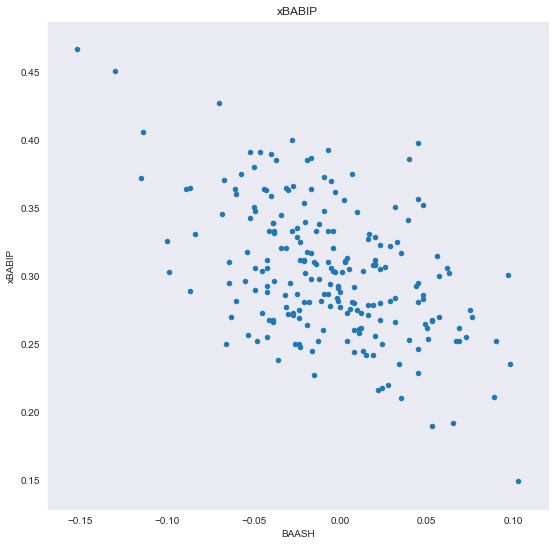

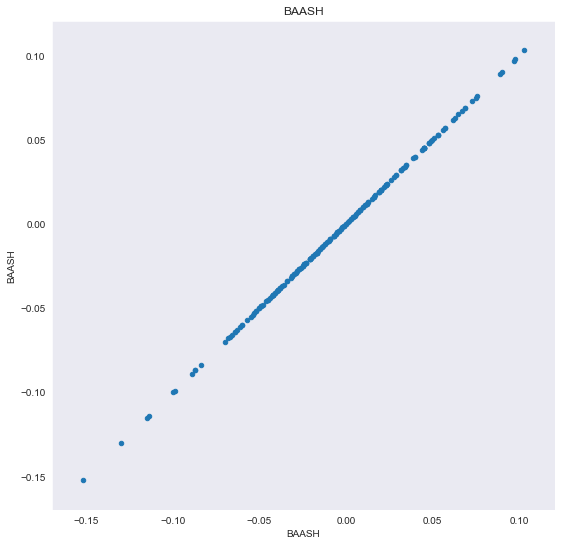

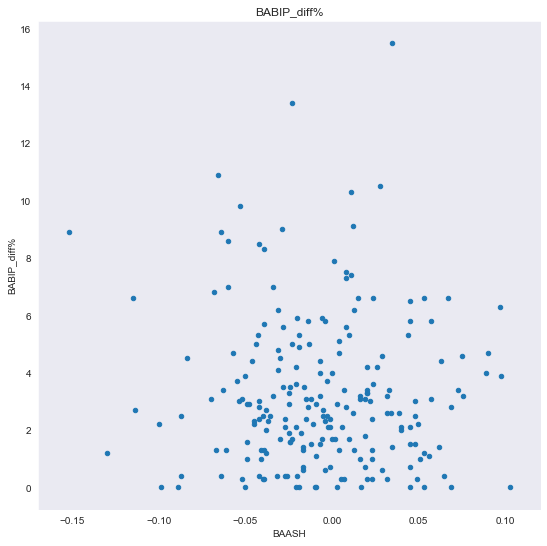

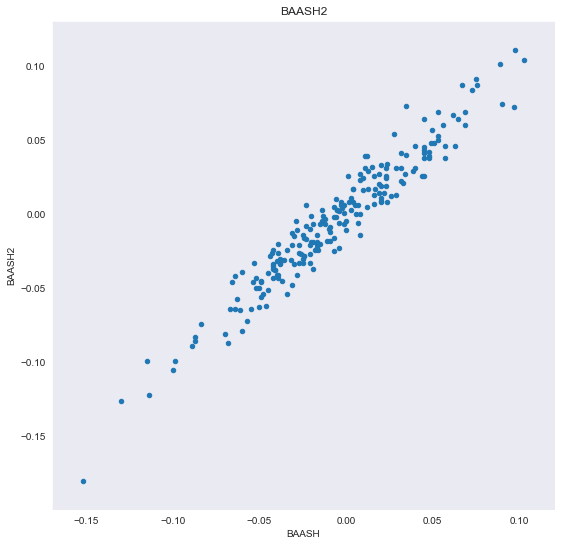

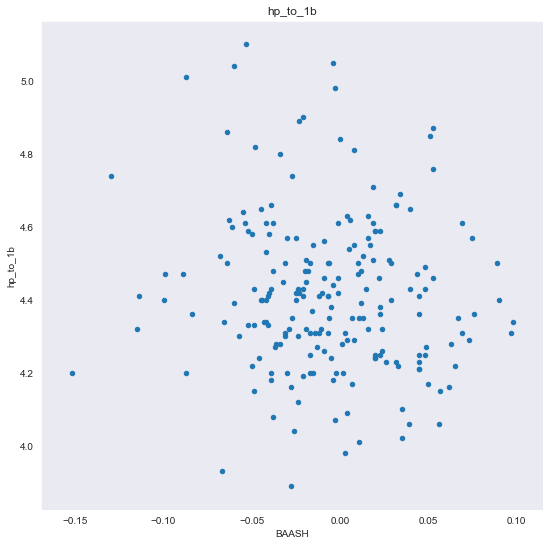

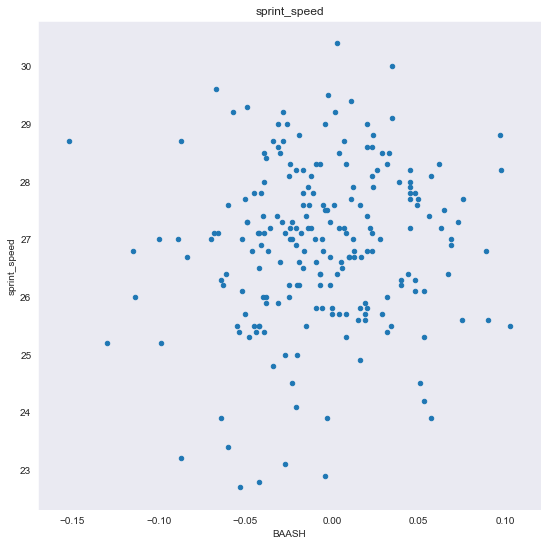

In [198]:
for col in results:
    try:
        results.plot(x='BAASH', y=col, kind='scatter', title=col, figsize=(9,9))
    except:
        pass

#### Notes

- My calculated BABIP numbers are a bit off in some cases...
    - Don't seem too far off though
- BAASH leader Gary Sanchez (???) has a very low statcast xBA; look into this
- **My hypothesis about BAASH was incorrect**
    - It doesn't separate hard hitters from fast runners